# Praxisteil 0: Posterior Sampling from Scratch

In [160]:
import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import scipy

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [181]:
df = pd.read_csv('../data/dataset_sim_normalmodel.csv')
df.head()

,height
0,170.414526
1,182.146265
2,183.708331
3,184.754210
4,187.548022


## Walkthrough one sample

### Prior distribution

In [ ]:
# Distribution parameters
prior_mu_mu = 170
prior_mu_sigma = 30

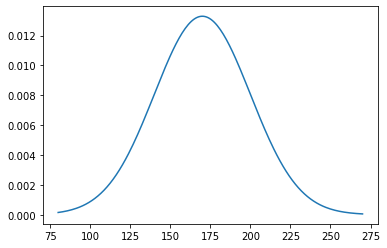

In [213]:
# Plot distribution
mu_x = np.linspace(80, 270, 200)
mu_y = scipy.stats.norm(prior_mu_mu, prior_mu_sigma).pdf(mu_x)
plt.plot(mu_x,mu_y)

In [211]:
# Draw one sample from this distribution
prior_mu_draw = np.random.normal(loc=prior_mu_mu,scale=prior_mu_sigma,size=1)
prior_mu_draw

array([162.17418223])

### Likelihood

In [183]:
# Data is assumed to be normal distributed, hence the likelihood is a normal pdf
scipy.stats.norm.pdf(x=3, loc=3, scale=1)

0.3989422804014327

<AxesSubplot:>

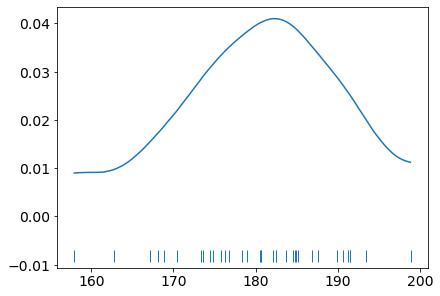

In [184]:
# This is the data we observe (with a density estimate)
az.plot_kde(df.height,rug=True)

In [216]:
# For a given location (mu) and scale (sigma) parameter, we can determine the likelihood of observations
obs_likelihood = scipy.stats.norm.pdf(x=df.height, loc=180, scale=20)
obs_likelihood

array([0.01778282, 0.01983259, 0.01960716, 0.01939143, 0.01857597,
       0.01967963, 0.01930703, 0.01993521, 0.01704598, 0.01622954,
       0.01918909, 0.01893452, 0.01277543, 0.01762812, 0.01987787,
       0.01933924, 0.01731225, 0.01992208, 0.0195082 , 0.01979082,
       0.01942528, 0.01929737, 0.01692028, 0.01993849, 0.01993483,
       0.01879926, 0.01592161, 0.01979015, 0.01887191, 0.01701254,
       0.01689972, 0.01375464, 0.01669625, 0.01081884, 0.01959333])

In [217]:
# Multiplication of single observation likelihoods give us the likelihood of all data
data_likelihood = np.prod(obs_likelihood)
data_likelihood

8.62347383763791e-62

EXKURS: Die Parameter, welche die höchste Likelihood erzielen, wären die besten Schätzer auf Basis unserer Stichprobe ohne Vorwissen (Prior). In der frequentistischen Statistik nennt man dieses Verfahren Maximum Likelihood Estimation (MLE). 

### Posterior distribution

In [218]:
# Number of samples to draw
num_samples = 1000

# Preallocate stuff
df_tmp = pd.DataFrame(columns=['mu','prior_mu_prob','likelihood','posterior_mu_prob'])
df_results = pd.DataFrame(columns=['mu','prior_mu_prob','likelihood','posterior_mu_prob'])

for i in range(num_samples):

    # draw one mu from prior distribution
    mu = np.random.normal(loc=prior_mu_mu,scale=20,size=1)

    # Probability of prior mu
    prior_mu_prob = scipy.stats.norm.pdf(x=mu, loc=prior_mu_mu, scale=prior_mu_sigma)
    
    # evaluate mu based on the data
    likelihood = np.prod(scipy.stats.norm.pdf(x=df.height, loc=mu, scale=20))
    
    # Posterior is proportional to prior times likelihood
    posterior_mu_prob = prior_mu_prob * likelihood
    
    # store 
    df_tmp['mu'] = mu
    df_tmp['prior_mu_prob'] = prior_mu_prob
    df_tmp['likelihood'] = likelihood
    df_tmp['posterior_mu_prob'] = posterior_mu_prob
    df_results = df_results.append(df_tmp)
    
df_results.head(5)

,mu,prior_mu_prob,likelihood,posterior_mu_prob
0,167.004581,0.013232,3.708169e-65,4.906632e-67
0,180.963536,0.012439,8.506215e-62,1.058094e-63
0,168.327625,0.013277,1.604443e-64,2.130288e-66
0,132.748838,0.006152,8.721300e-105,5.364947e-107
0,169.284871,0.013294,4.208496e-64,5.594901e-66


(100.0, 250.0)

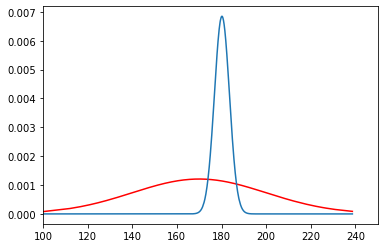

In [219]:
# Sort values
df_results.sort_values('mu',inplace=True)

# Plot
plt.plot(df_results.mu,df_results.prior_mu_prob/np.sum(df_results.prior_mu_prob), color='red')
plt.plot(df_results.mu,df_results.posterior_mu_prob/np.sum(df_results.posterior_mu_prob))
plt.xlim([100, 250])

## With pymc3 

In [220]:
with pm.Model() as normal_model:
    
    # Prior: mu as normal distribution
    mu = pm.Normal('mu', mu=170, sigma=30)
    
    # Normal Likelihood with mu prior and fixed sigma inkl. observations 
    y = pm.Normal('y',mu=mu,sigma=20,observed=df.height)

In [221]:
# Sample from the model
with normal_model:
    trace_nm = pm.sample(**{'chains': 4,'cores': 4})

/opt/conda/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/opt/conda/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'mu'}>

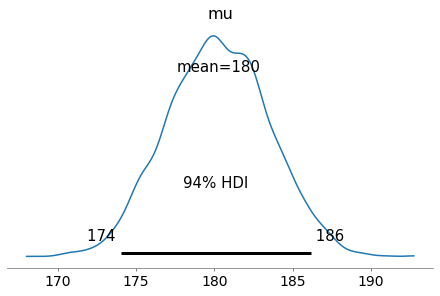

In [222]:
# Plot posterior density 
az.plot_posterior(trace_nm, var_names=['mu'])

In [223]:
# Extract posterior samples from trace 
trace_nm['mu']

array([184.71964373, 175.3821247 , 177.04741119, ..., 175.80873502,
       178.46914302, 178.46914302])

(100.0, 250.0)

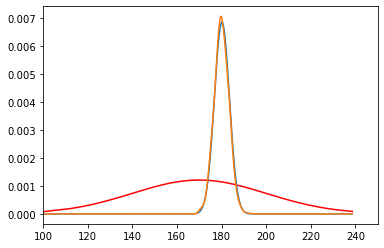

In [224]:
# Add pymc3 output to above model

plt.plot(df_results.mu,df_results.prior_mu_prob/np.sum(df_results.prior_mu_prob), color='red')
plt.plot(df_results.mu,df_results.posterior_mu_prob/np.sum(df_results.posterior_mu_prob))

plt.plot(df_results.mu,density(df_results.mu)/np.sum(density(df_results.mu)))

plt.xlim([100, 250])
